## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'BA'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-38.06390,-11.19780,167.120,978164.67,978172.505249,-7.835249
1,-38.00970,-11.19680,149.150,978191.76,978191.133315,0.626685
2,-39.51830,-15.80270,259.930,978337.62,978338.244076,-0.624076
3,-39.52100,-15.85990,201.440,978346.38,978353.447203,-7.067203
4,-38.35250,-11.78610,167.380,978136.04,978148.472334,-12.432334
...,...,...,...,...,...,...
781,-40.19993,-13.83293,290.147,978230.52,978240.522812,-10.002812
782,-40.18194,-13.85558,200.814,978250.77,978265.956294,-15.186294
783,-40.06950,-13.87800,189.255,978257.65,978260.268740,-2.618740
784,-40.03238,-13.88344,183.249,978258.23,978270.711485,-12.481486


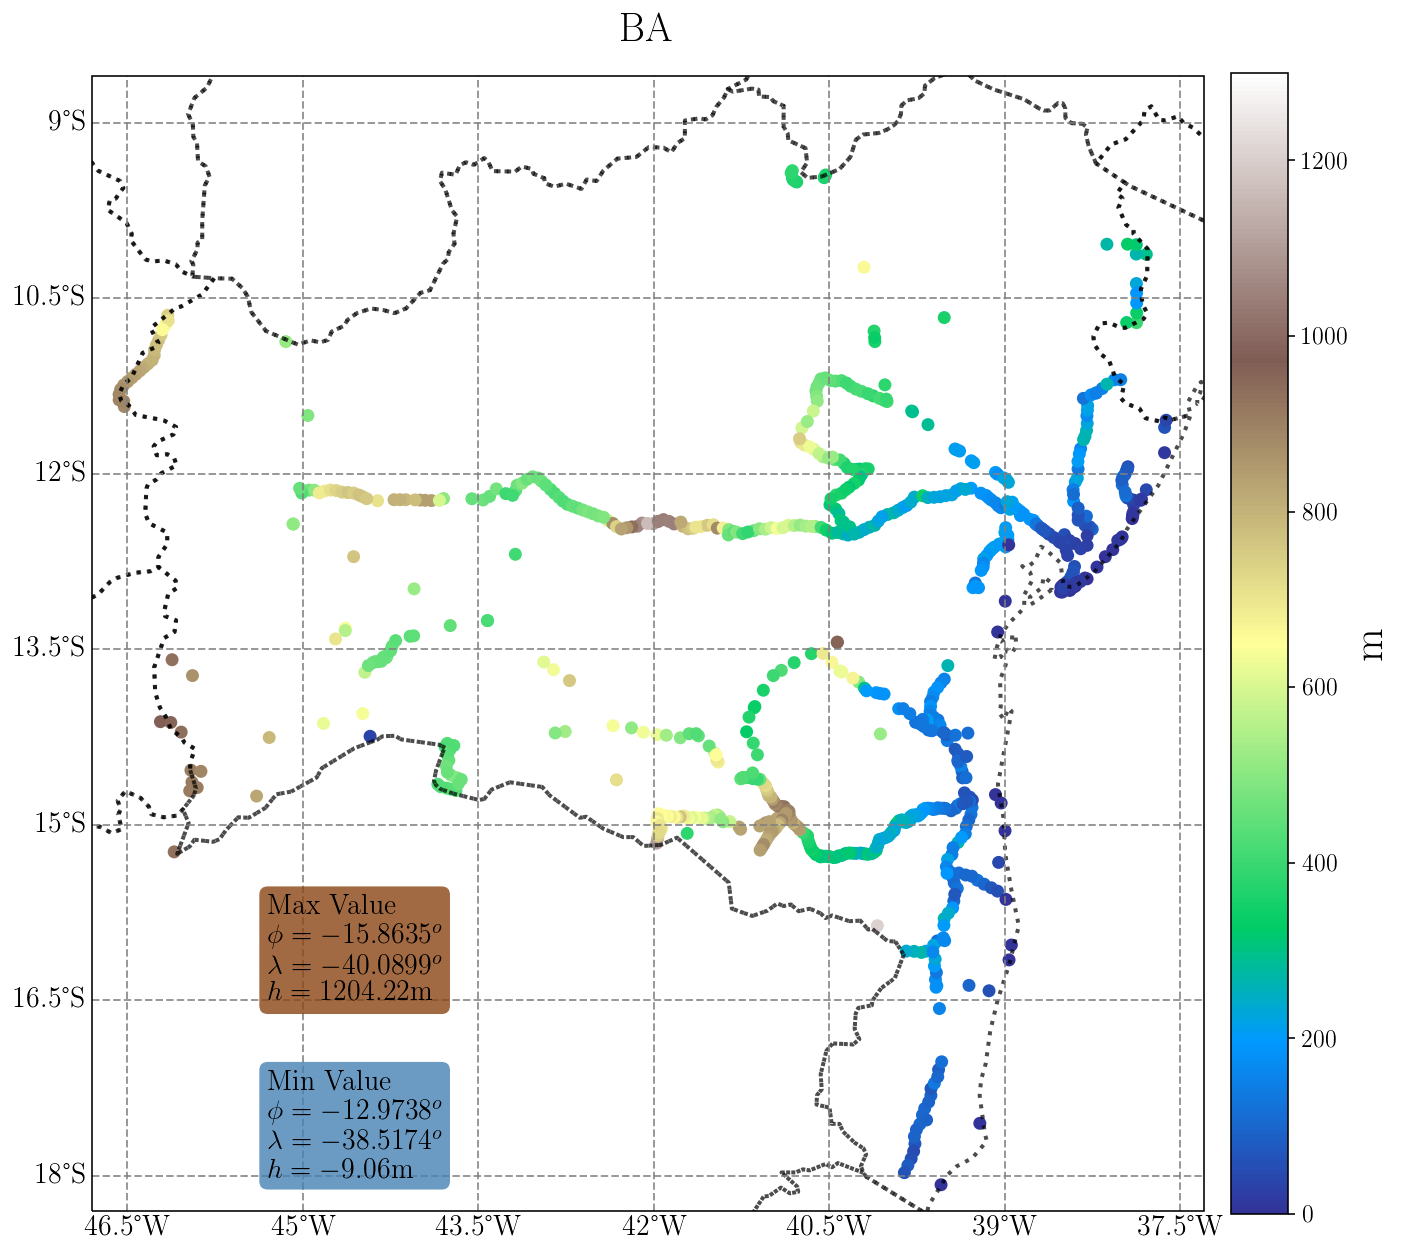

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(12.,14.), region=[-46.8,-37.3,-18.3,-8.6], \
          sign=(-45.3,-45.3,-16.5,-18.), shrink=0.75, cmap='terrain', lim_val=(True,True,0.,1300.))

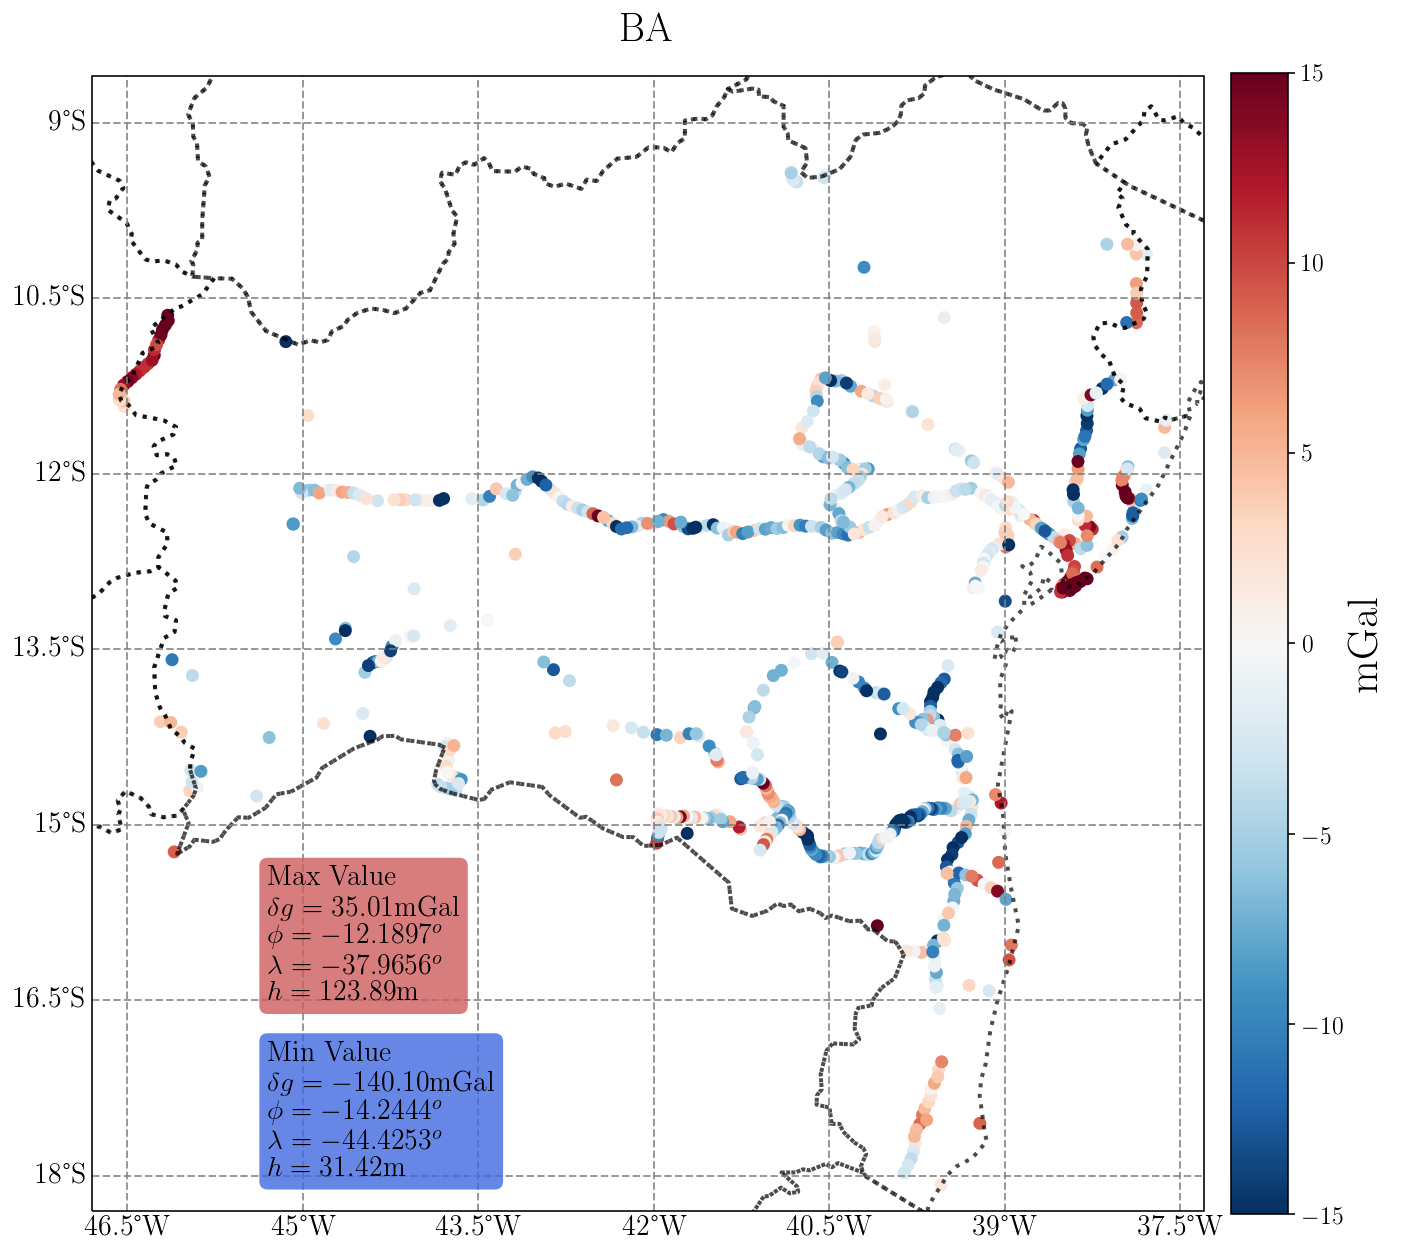

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-46.8,-37.3,-18.3,-8.6], \
          sign=(-45.3,-45.3,-16.5,-18.), shrink=0.75, lim_val=(True, 15.))

In [8]:
index = np.argmax(df.ALT.values)
print('MAX', index, df.ALT[index], df.DIST[index])

index = np.argmin(df.ALT.values)
print('MIN', index, df.ALT[index], df.DIST[index])

MAX 657 1204.22 25.38006320002023
MIN 709 -9.057 7.933533099945635


In [9]:
index = np.argmax(df.DIST.values)
print('MAX', index, df.ALT[index], df.DIST[index])

index = np.argmin(df.DIST.values)
print('MIN', index, df.ALT[index], df.DIST[index])

MAX 96 123.89 35.00589489995036
MIN 72 31.42 -140.09669469983783


### Calculating rotation matrices and Cartesian coordinates

In [10]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))

## Estimating the first set of point-mass parameters

In [11]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [12]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-15
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [13]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]

In [14]:
Rcl = R[:, indl]

In [15]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(786, 786)


In [16]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [17]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

786


In [18]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [19]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

0.07999999995810292

In [20]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [21]:
rabs_max.append(rabs_max_l)

In [22]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

0.07999999995810292


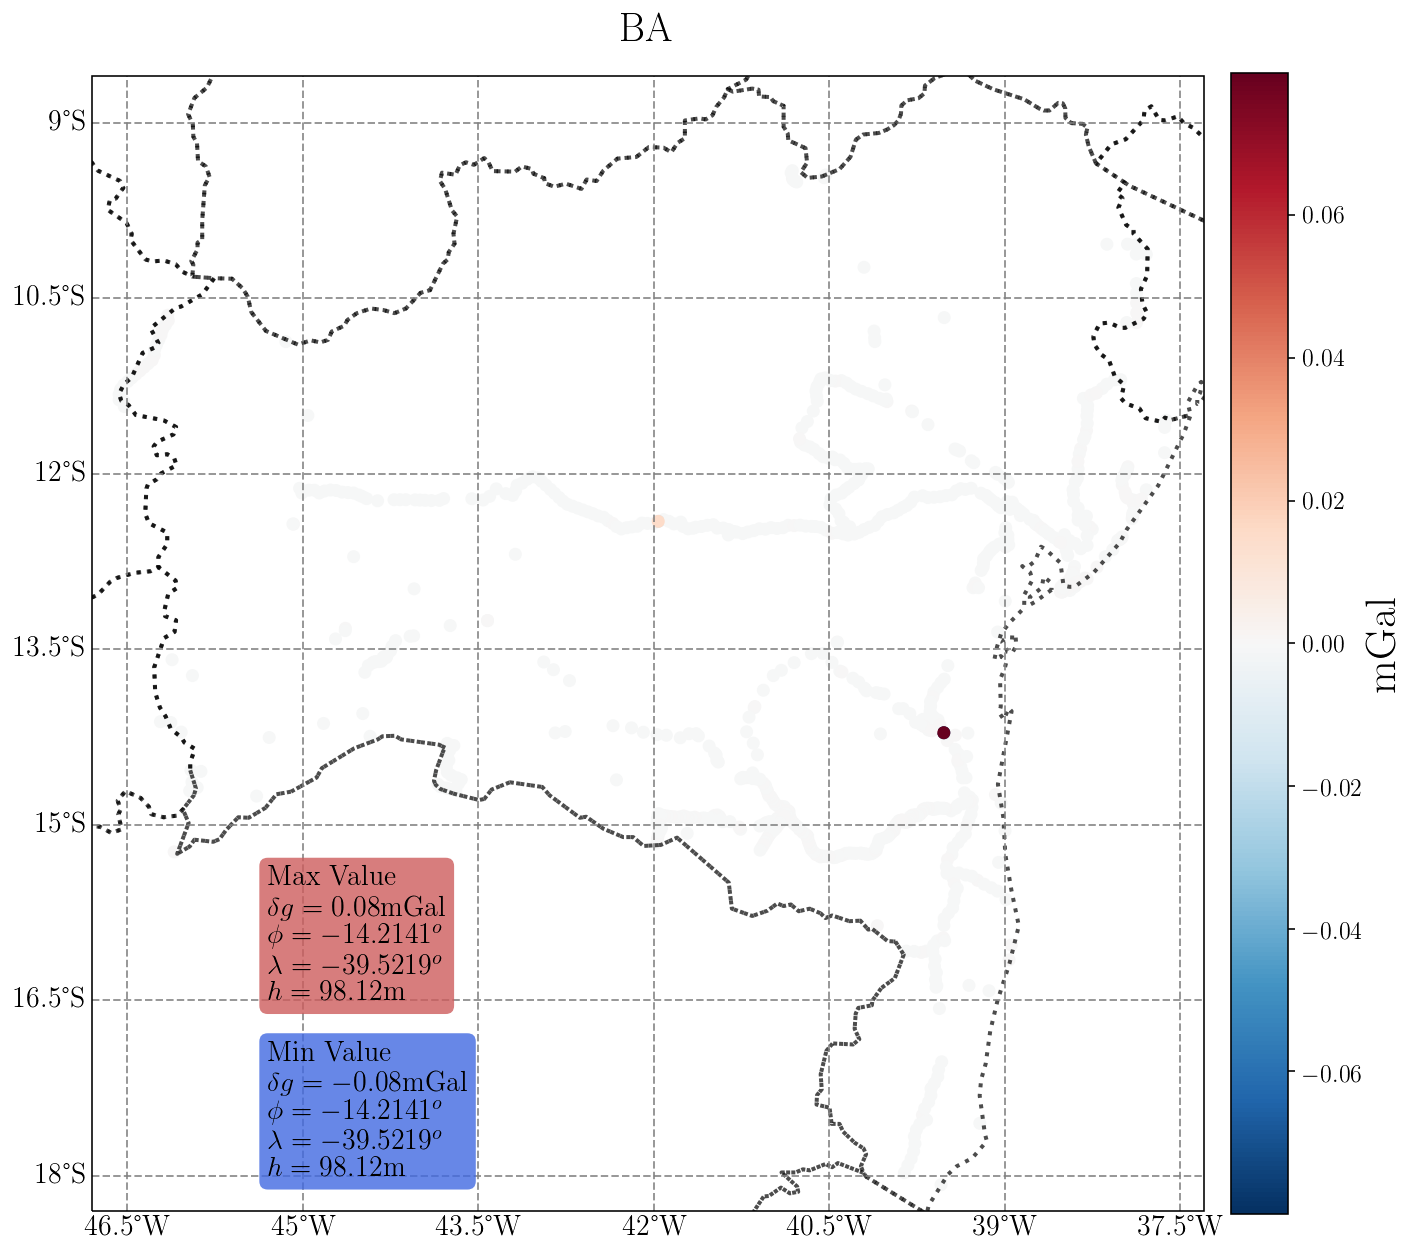

In [23]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(12.,14.), region=[-46.8,-37.3,-18.3,-8.6], \
          sign=(-45.3,-45.3,-16.5,-18.), shrink=0.75, lim_val=(True, 1e-2), \
          save='../figs/'+uf+'_res.png')

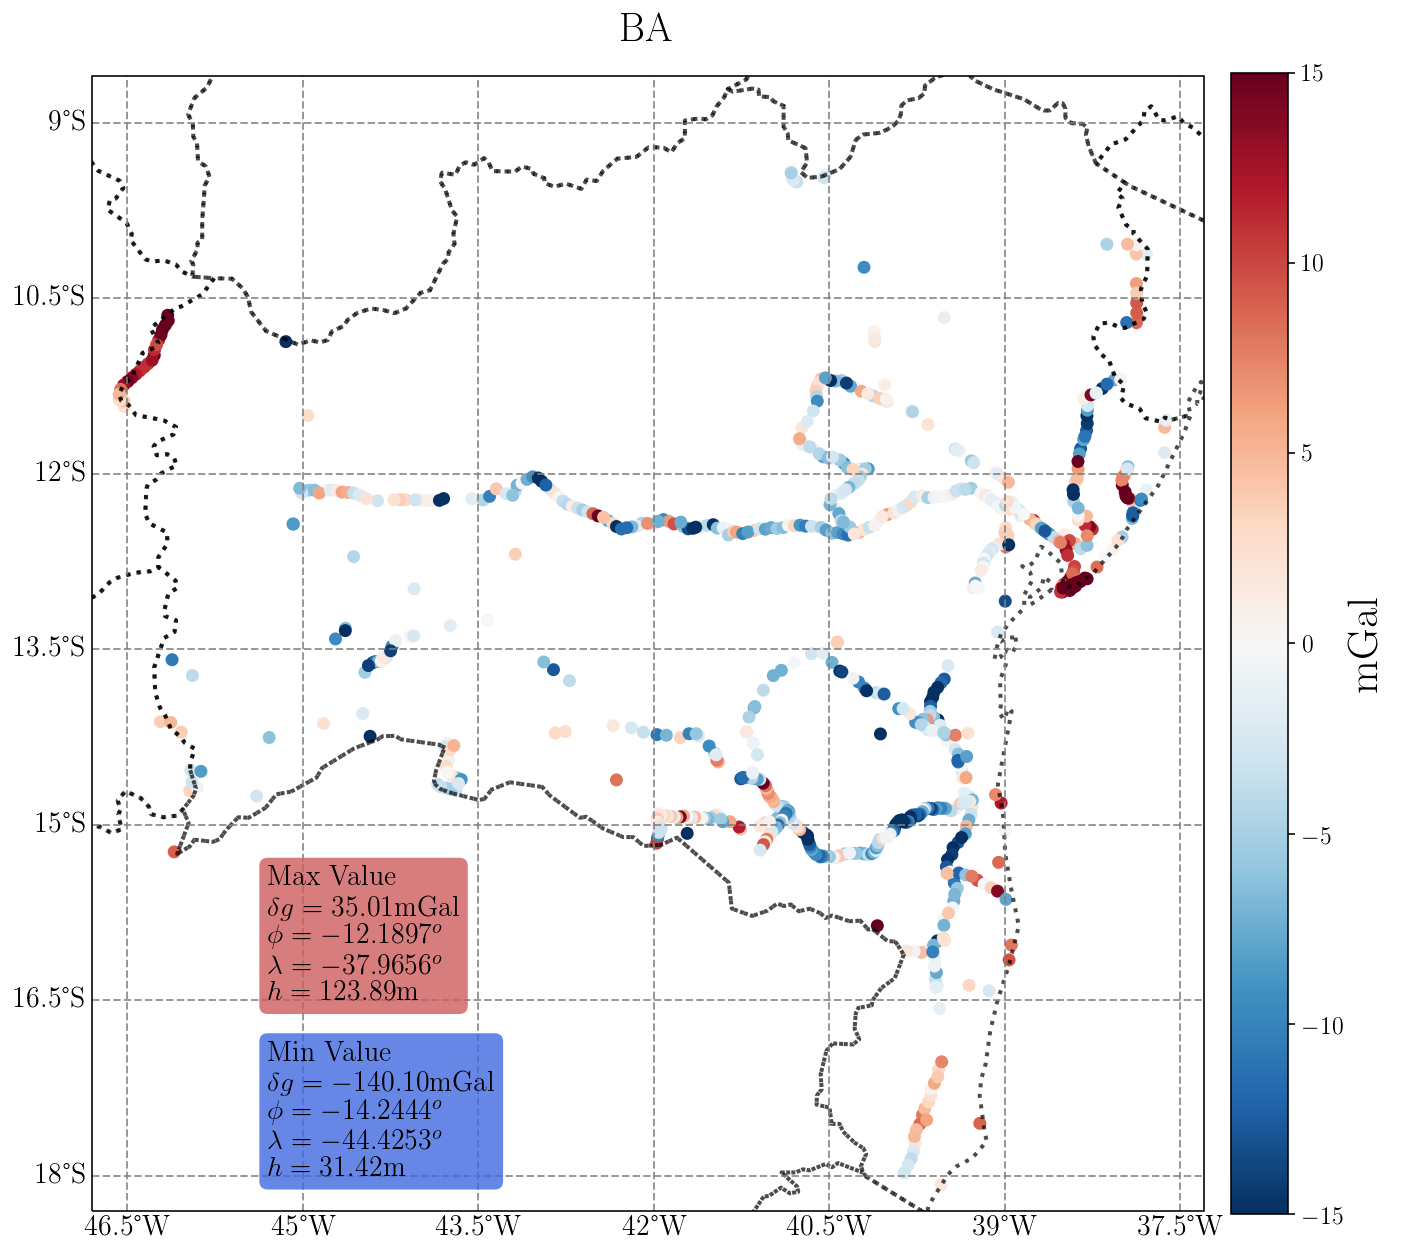

In [24]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-46.8,-37.3,-18.3,-8.6], \
          sign=(-45.3,-45.3,-16.5,-18.), shrink=0.75, lim_val=(True, 15.), \
          save='../figs/'+uf+'_dist.png')

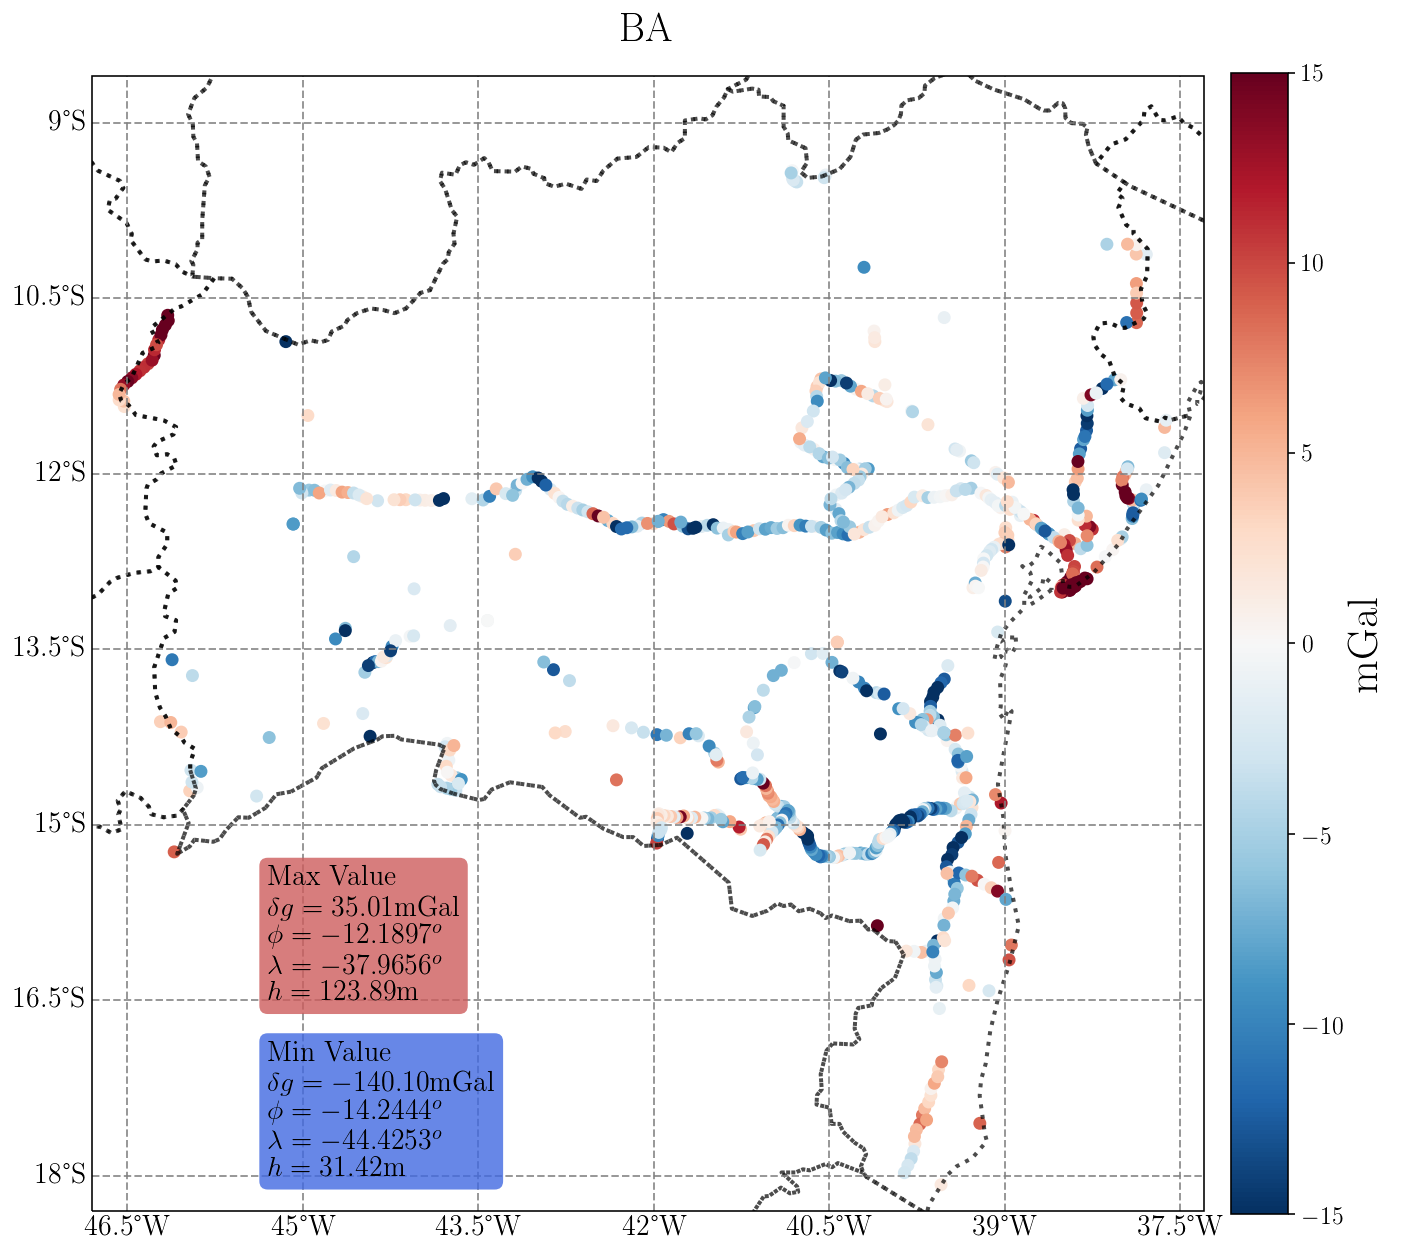

In [25]:
point_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), region=[-46.8,-37.3,-18.3,-8.6], \
          sign=(-45.3,-45.3,-16.5,-18.), shrink=0.75, lim_val=(True, 15.), \
          save='../figs/'+uf+'_pred.png')

In [26]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [27]:
new_data = {'LONG':bdg.LONG.values, \
            'LAT':bdg.LAT.values, \
            'ALT':bdg.ALT_GEOM.values, \
            'BDG':bdg.GRAV.values, \
            'EIGEN':eigen.GRAV.values, \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-38.06390,-11.19780,167.120,978164.67,978172.505249,-7.835249,-2.631971e+12,-2.220446e-14
1,-38.00970,-11.19680,149.150,978191.76,978191.133315,0.626685,5.613984e+11,3.996803e-15
2,-39.51830,-15.80270,259.930,978337.62,978338.244076,-0.624076,-9.796261e+10,1.110223e-15
3,-39.52100,-15.85990,201.440,978346.38,978353.447203,-7.067203,-2.565956e+12,7.105427e-15
4,-38.35250,-11.78610,167.380,978136.04,978148.472334,-12.432334,-4.018649e+12,1.953993e-14
...,...,...,...,...,...,...,...,...
781,-40.19993,-13.83293,290.147,978230.52,978240.522812,-10.002812,-1.802983e+12,-1.776357e-15
782,-40.18194,-13.85558,200.814,978250.77,978265.956294,-15.186294,-4.740314e+12,-1.598721e-14
783,-40.06950,-13.87800,189.255,978257.65,978260.268740,-2.618740,6.348886e+11,8.881784e-16
784,-40.03238,-13.88344,183.249,978258.23,978270.711485,-12.481486,-4.508770e+12,-1.776357e-14


In [28]:
print(df.RESID.min(), df.RESID.max())

-0.07999999995807805 0.07999999995810292


### Upward Continuation

In [29]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [30]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


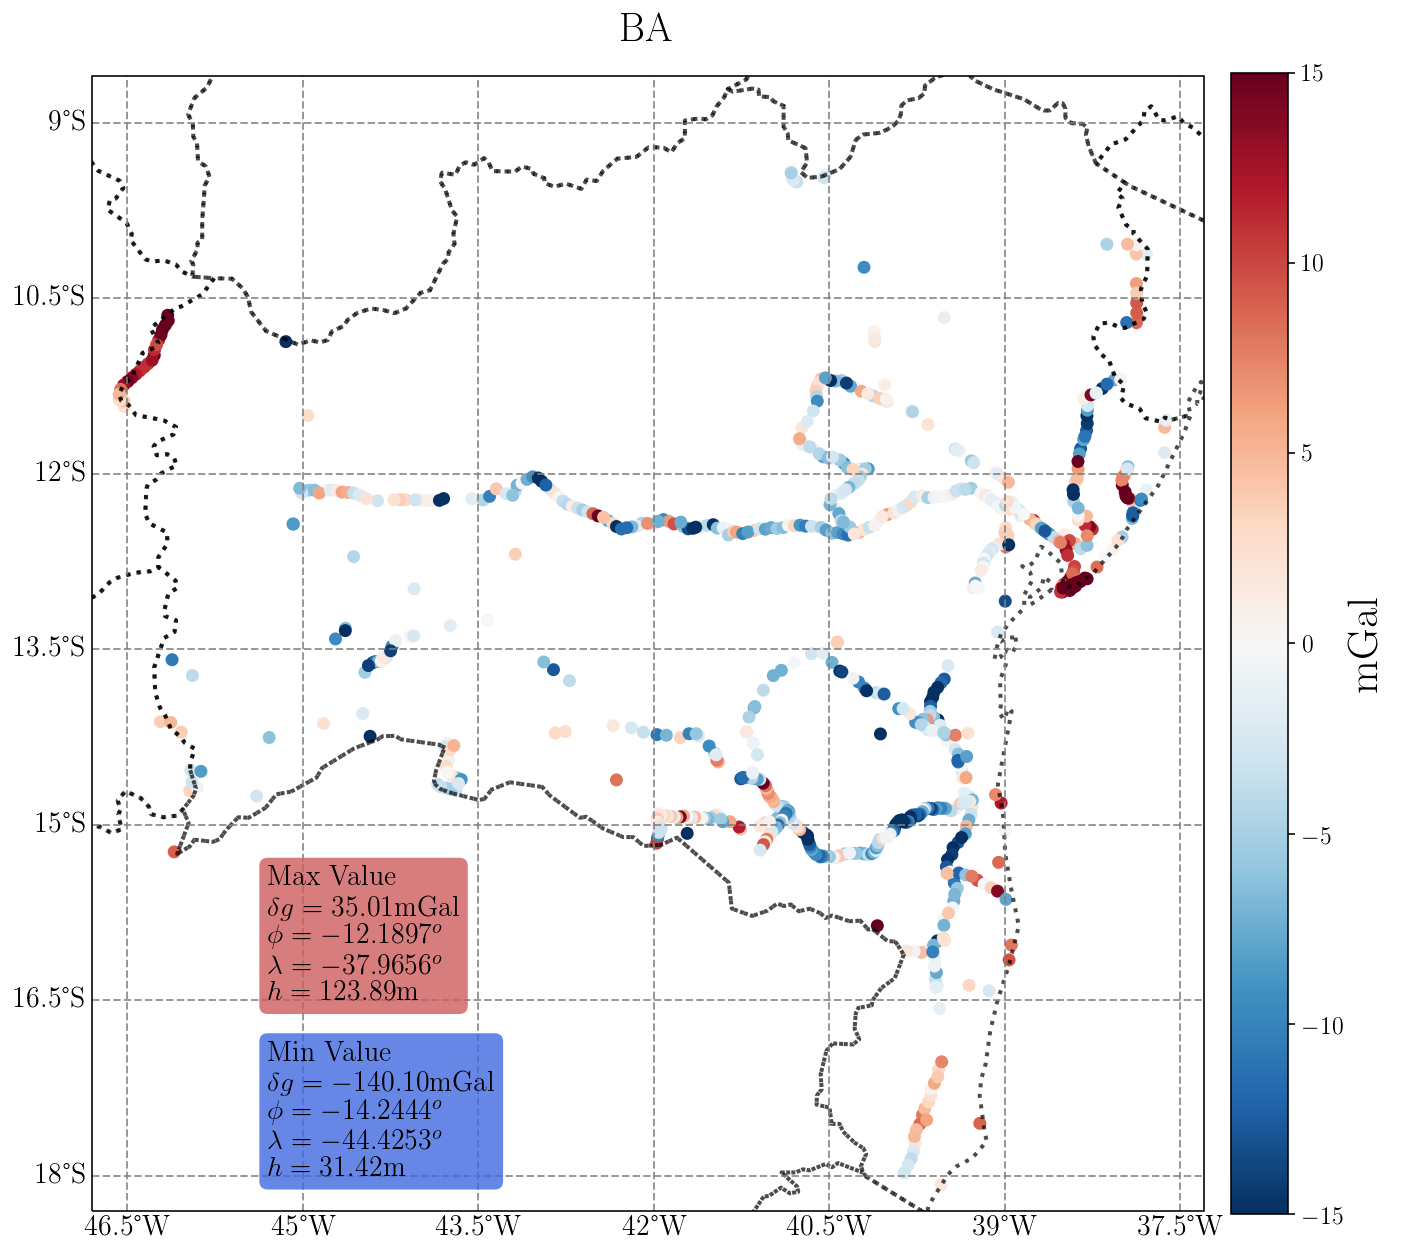

In [31]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-46.8,-37.3,-18.3,-8.6], \
          sign=(-45.3,-45.3,-16.5,-18.), shrink=0.75, lim_val=(True, 15.))

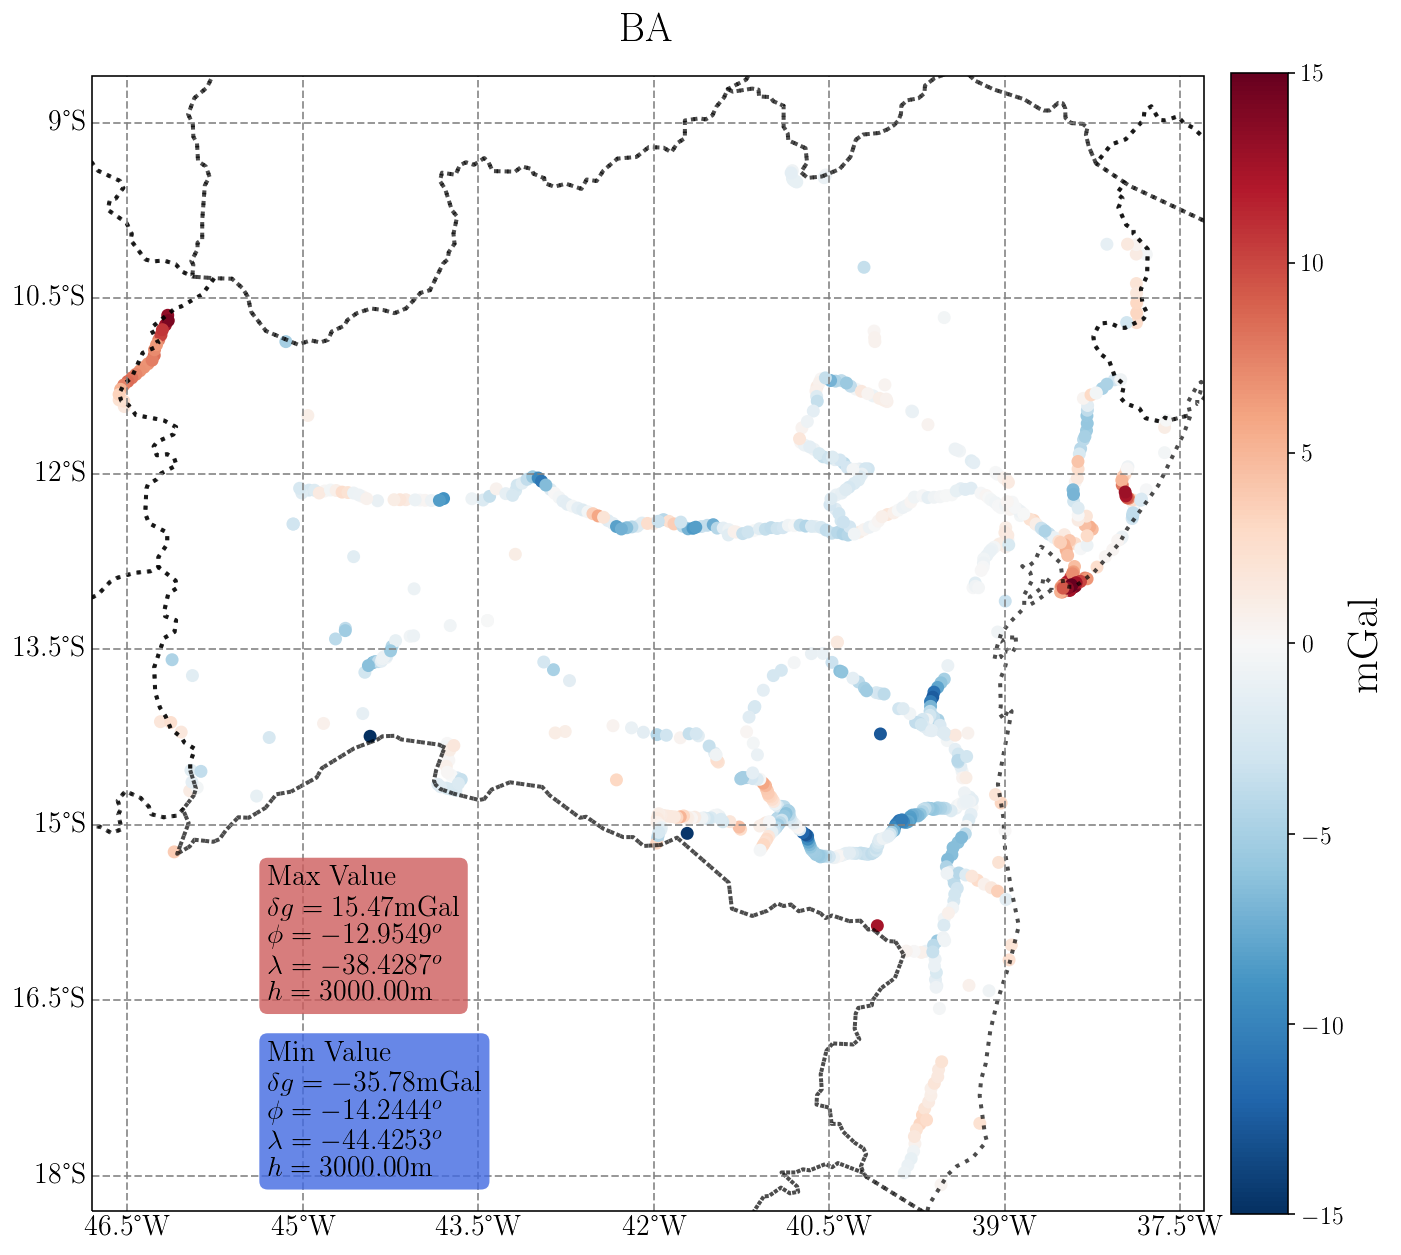

In [32]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(12.,14.), \
          region=[-46.8,-37.3,-18.3,-8.6], sign=(-45.3,-45.3,-16.5,-18.), shrink=0.75, lim_val=(True, 15.))

In [33]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


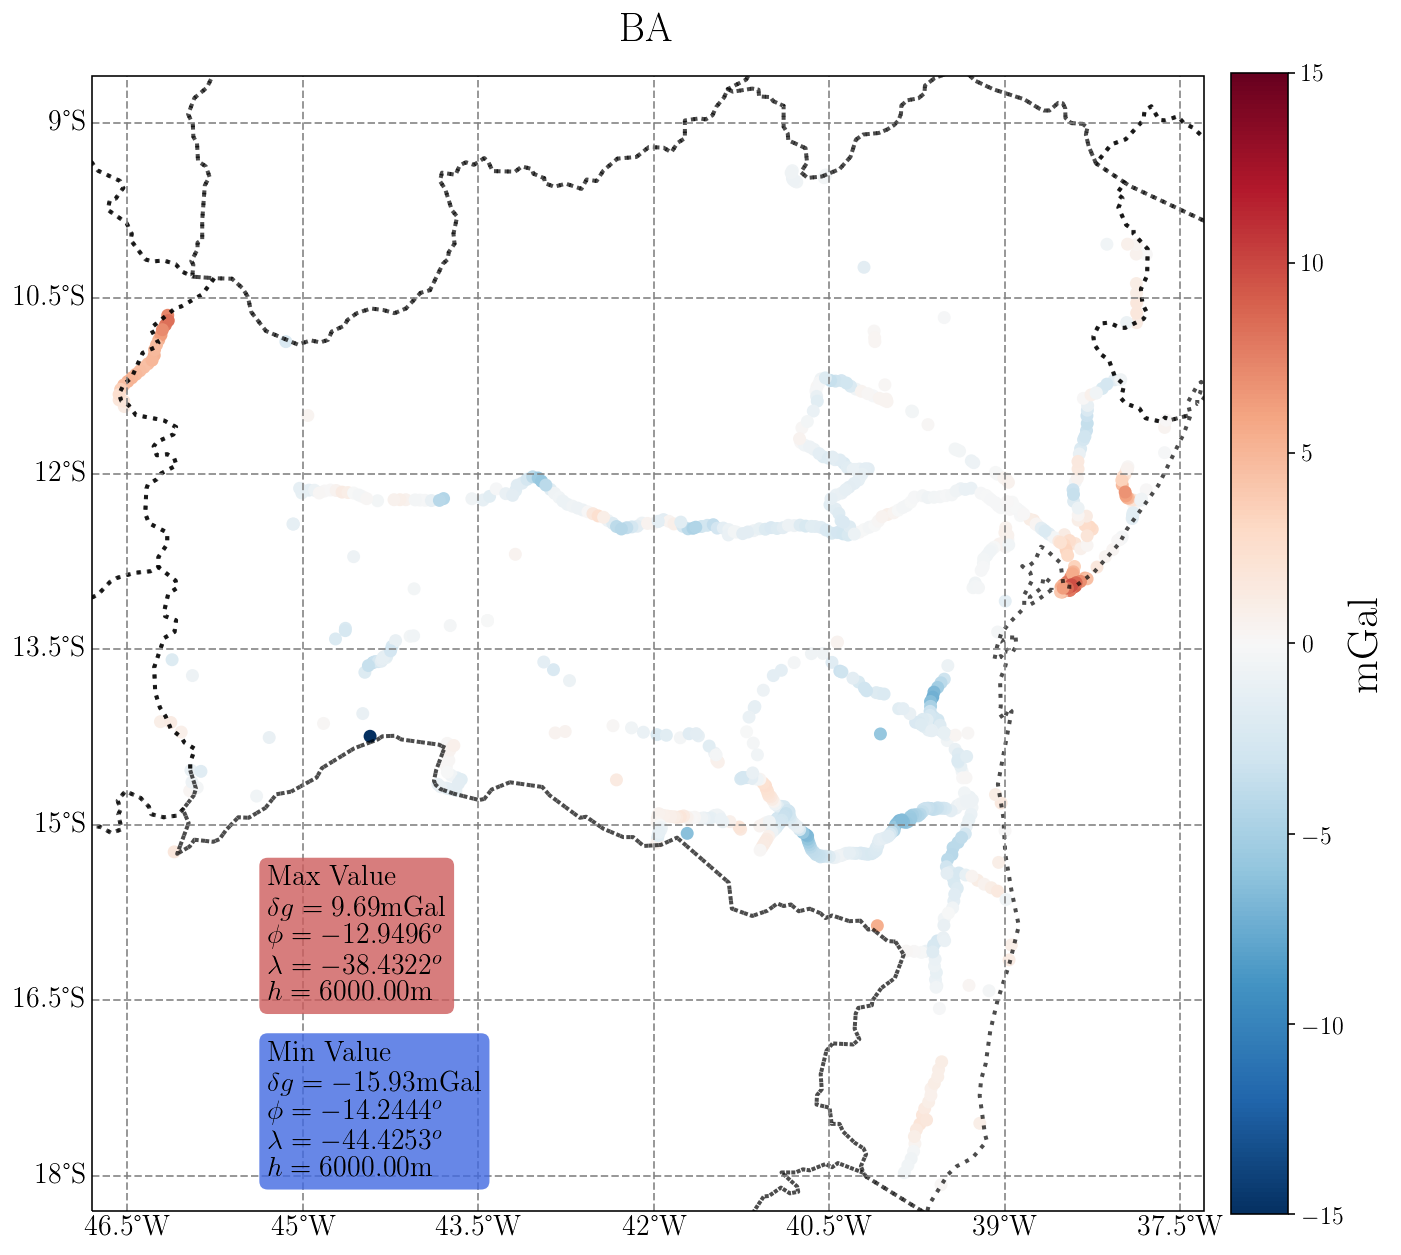

In [34]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(12.,14.), \
          region=[-46.8,-37.3,-18.3,-8.6], sign=(-45.3,-45.3,-16.5,-18.), shrink=0.75, lim_val=(True, 15.))

In [35]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


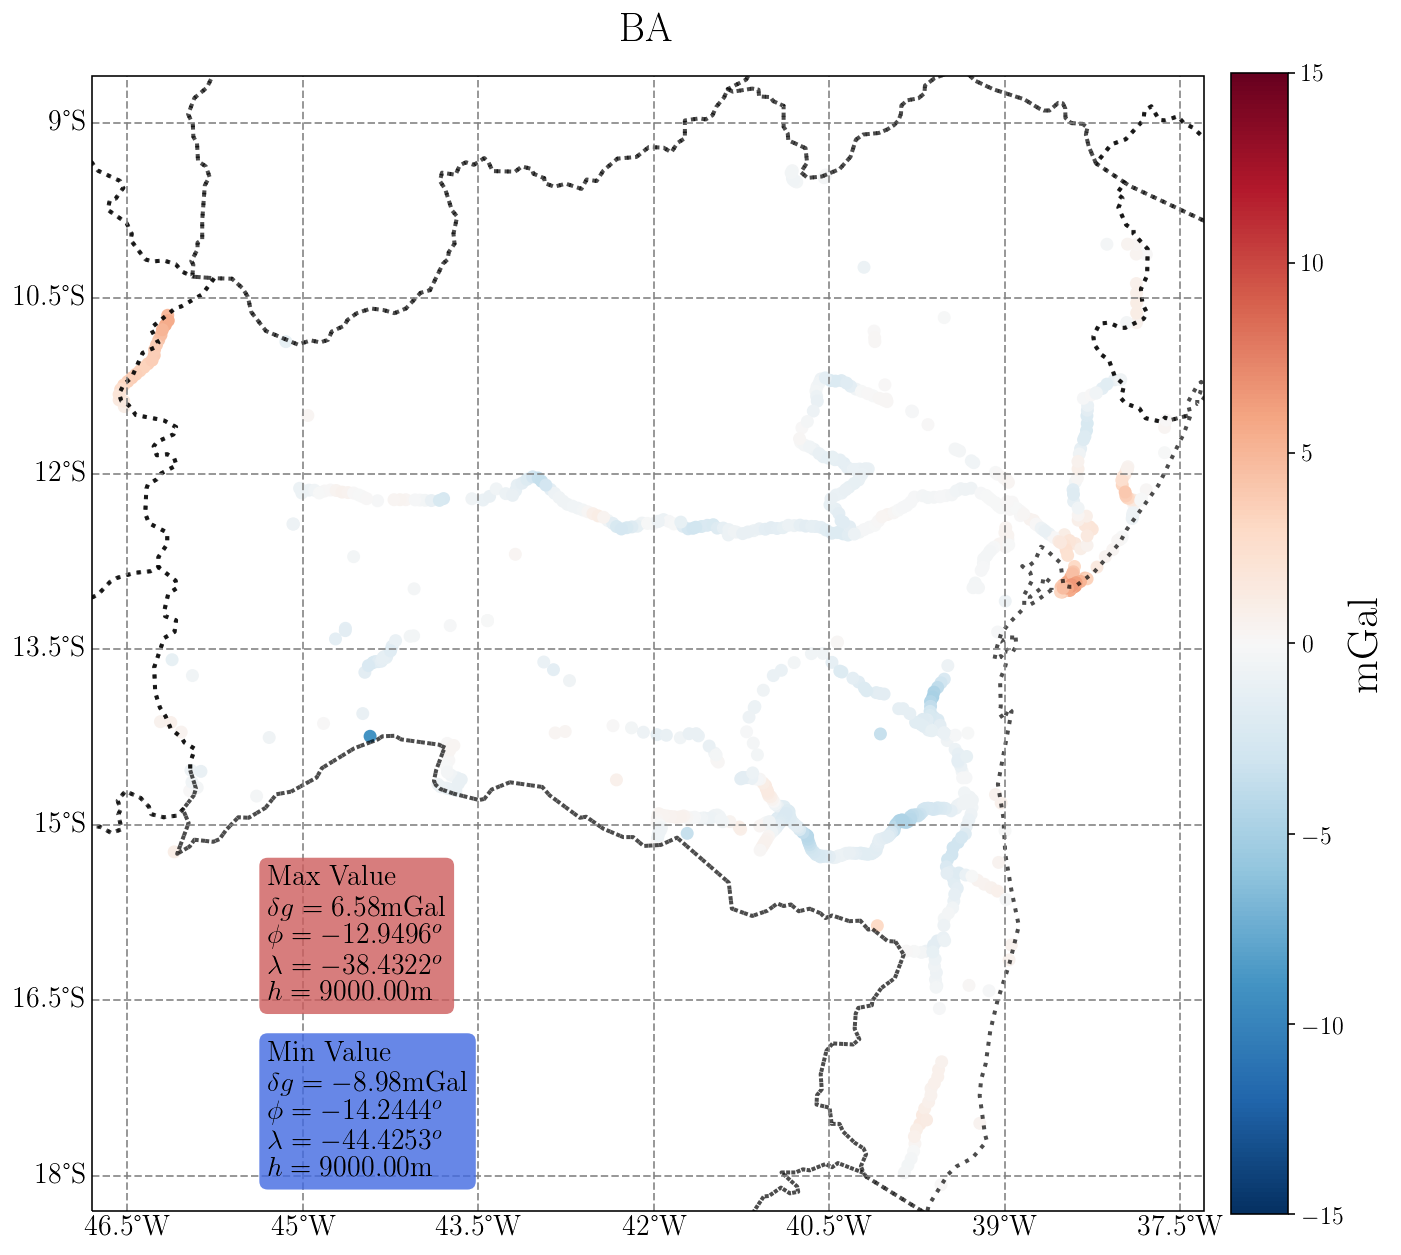

In [36]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(12.,14.), \
          region=[-46.8,-37.3,-18.3,-8.6], sign=(-45.3,-45.3,-16.5,-18.), shrink=0.75, lim_val=(True, 15.))